<a href="https://colab.research.google.com/github/saadatialirezam-create/glaucoma-detection/blob/main/03_randomforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from google.colab import drive
from pathlib import Path

## Load Splits

In [2]:
drive.mount('/content/drive')

train = np.load("/content/drive/MyDrive/Glaucoma_data/splits/train_split.npz")
test  = np.load("/content/drive/MyDrive/Glaucoma_data/splits/test_split.npz")

X_train = train["X"]
y_train = train["y"]
X_test  = test["X"]
y_test  = test["y"]

if X_train.ndim == 4 and X_train.shape[-1] == 1:
    X_train = X_train[..., 0]
if X_test.ndim == 4 and X_test.shape[-1] == 1:
    X_test = X_test[..., 0]

print("Train:", X_train.shape, y_train.shape, X_train.dtype)
print("Test :", X_test.shape,  y_test.shape,  X_test.dtype)

Mounted at /content/drive
Train: (1898, 224, 224) (1898,) uint8
Test : (475, 224, 224) (475,) uint8


##GLCM feature extraction

In [3]:
from skimage.feature import graycomatrix, graycoprops

LEVELS = 32

distances = [1]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

props = ["dissimilarity", "correlation", "homogeneity", "contrast", "ASM", "energy"]

def to_uint8(img):

    if img.dtype == np.uint8:
        return img
    img = img.astype(np.float32)
    if img.max() <= 1.0:
        img = img * 255.0
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def quantize_levels(img_uint8, levels=32):

    bin_size = 256 // levels
    q = (img_uint8 // bin_size).astype(np.uint8)
    q[q >= levels] = levels - 1
    return q

def glcm_features(img):

    img_u8 = to_uint8(img)
    img_q = quantize_levels(img_u8, levels=LEVELS)

    glcm = graycomatrix(
        img_q,
        distances=distances,
        angles=angles,
        levels=LEVELS,
        symmetric=True,
        normed=True
    )

    feat = []
    for p in props:
        vals = graycoprops(glcm, p)  # shape: (len(distances), len(angles))
        feat.append(vals.mean())
    return np.array(feat, dtype=np.float32)

def build_feature_matrix(X):
    F = np.zeros((X.shape[0], len(props)), dtype=np.float32)
    for i in range(X.shape[0]):
        F[i] = glcm_features(X[i])
        if (i+1) % 100 == 0:
            print(f"Processed {i+1}/{X.shape[0]}")
    return F

print("Extracting GLCM features for TRAIN...")
Xtr_feat = build_feature_matrix(X_train)

print("Extracting GLCM features for TEST...")
Xte_feat = build_feature_matrix(X_test)

print("Feature matrix train/test:", Xtr_feat.shape, Xte_feat.shape)
print("Feature names:", props)

Extracting GLCM features for TRAIN...
Processed 100/1898
Processed 200/1898
Processed 300/1898
Processed 400/1898
Processed 500/1898
Processed 600/1898
Processed 700/1898
Processed 800/1898
Processed 900/1898
Processed 1000/1898
Processed 1100/1898
Processed 1200/1898
Processed 1300/1898
Processed 1400/1898
Processed 1500/1898
Processed 1600/1898
Processed 1700/1898
Processed 1800/1898
Extracting GLCM features for TEST...
Processed 100/475
Processed 200/475
Processed 300/475
Processed 400/475
Feature matrix train/test: (1898, 6) (475, 6)
Feature names: ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']


##Train Random Forest

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf.fit(Xtr_feat, y_train)

y_prob = rf.predict_proba(Xte_feat)[:, 1]
y_pred = (y_prob >= 0.5).astype(np.int64)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
cm = confusion_matrix(y_test, y_pred)

print("\n--- Random Forest Test Metrics ---")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("Confusion Matrix:\n", cm)


--- Random Forest Test Metrics ---
Accuracy : 0.6778947368421052
Precision: 0.6111111111111112
Recall   : 0.3728813559322034
F1       : 0.4631578947368421
Confusion Matrix:
 [[256  42]
 [111  66]]


## Confusion Matrix

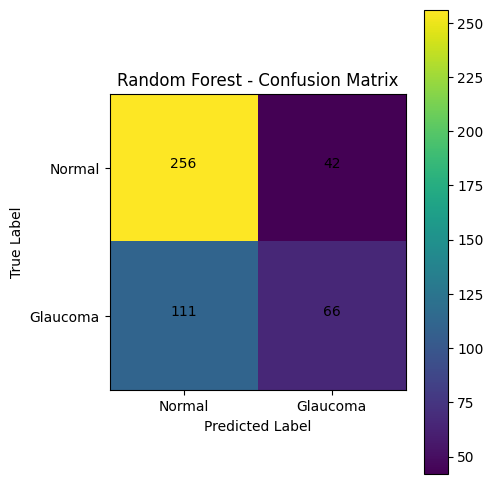

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Random Forest - Confusion Matrix")
plt.colorbar()

classes = ["Normal", "Glaucoma"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

##Save outputs to Drive (for ensemble)

In [7]:
import joblib

SAVE_DIR = Path("/content/drive/MyDrive/Glaucoma_data/preds")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

np.save(SAVE_DIR / "y_true.npy", y_test)
np.save(SAVE_DIR / "rf_prob.npy", y_prob)
np.save(SAVE_DIR / "rf_pred.npy", y_pred)

print("\nSaved predictions to:", SAVE_DIR)


Saved predictions to: /content/drive/MyDrive/Glaucoma_data/preds
